In [6]:
# ✅ Import Libraries
import numpy as np
import os
import cv2
import pickle
import matplotlib.pyplot as plt

from os import listdir
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# ✅ Use TensorFlow's Keras
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

In [14]:
# ✅ Parameters
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
IMG_DIMS = (256, 256, 3)
DATASET_DIR = "D:\ML PROJECTS\Plant Disease Detection with keras\PlantVillage"

In [15]:
# ✅ Image Preprocessing Function
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, IMG_DIMS[:2])
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [17]:
print("[INFO] Loading images...")
for disease_folder in listdir(DATASET_DIR):
    disease_path = os.path.join(DATASET_DIR, disease_folder)

    # ✅ Check if it's really a directory (to skip stray files)
    if not os.path.isdir(disease_path):
        continue

    print(f"[INFO] Processing {disease_folder}...")

    for img in listdir(disease_path)[:200]:  # Optional limit
        if img.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(disease_path, img)
            img_array = convert_image_to_array(img_path)
            if img_array.size > 0:
                image_list.append(img_array)
                label_list.append(disease_folder)


[INFO] Loading images...
[INFO] Processing Pepper__bell___Bacterial_spot...
[INFO] Processing Pepper__bell___healthy...
[INFO] Processing PlantVillage...
[INFO] Processing Potato___Early_blight...
[INFO] Processing Potato___healthy...
[INFO] Processing Potato___Late_blight...
[INFO] Processing Tomato_Bacterial_spot...
[INFO] Processing Tomato_Early_blight...
[INFO] Processing Tomato_healthy...
[INFO] Processing Tomato_Late_blight...
[INFO] Processing Tomato_Leaf_Mold...
[INFO] Processing Tomato_Septoria_leaf_spot...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite...
[INFO] Processing Tomato__Target_Spot...
[INFO] Processing Tomato__Tomato_mosaic_virus...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus...


In [18]:
# ✅ Prepare Image and Label Data
np_image_list = np.array(image_list, dtype="float16") / 255.0
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer, open("label_transform.pkl", "wb"))
n_classes = len(label_binarizer.classes_)

In [19]:
# ✅ Split into Training and Testing Sets
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state=42)

In [20]:
# ✅ Data Augmentation
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2, horizontal_flip=True,
    fill_mode="nearest"
)

In [21]:
# ✅ CNN Architecture
model = Sequential()

model.add(Conv2D(32, (3, 3), padding="same", input_shape=IMG_DIMS))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [22]:
# ✅ Compile the Model
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

In [23]:
# ✅ Save Best Model Automatically
checkpoint = ModelCheckpoint("best_cnn_model.h5", monitor="val_accuracy", save_best_only=True, verbose=1)

In [24]:
# ✅ Train the Model
print("[INFO] Training model...")
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS,
    callbacks=[checkpoint],
    verbose=1
)

[INFO] Training model...
Epoch 1/25
73/73 [==============================] - ETA: 0s - loss: 2.0429 - accuracy: 0.4324
Epoch 1: val_accuracy improved from -inf to 0.06261, saving model to best_cnn_model.h5
73/73 [==============================] - 106s 1s/step - loss: 2.0429 - accuracy: 0.4324 - val_loss: 21.5900 - val_accuracy: 0.0626
Epoch 2/25
73/73 [==============================] - ETA: 0s - loss: 1.3188 - accuracy: 0.6067
Epoch 2: val_accuracy did not improve from 0.06261
73/73 [==============================] - 104s 1s/step - loss: 1.3188 - accuracy: 0.6067 - val_loss: 18.4313 - val_accuracy: 0.0626
Epoch 3/25
73/73 [==============================] - ETA: 0s - loss: 1.1733 - accuracy: 0.6492
Epoch 3: val_accuracy improved from 0.06261 to 0.06937, saving model to best_cnn_model.h5
73/73 [==============================] - 104s 1s/step - loss: 1.1733 - accuracy: 0.6492 - val_loss: 16.2604 - val_accuracy: 0.0694
Epoch 4/25
73/73 [==============================] - ETA: 0s - loss: 1.13

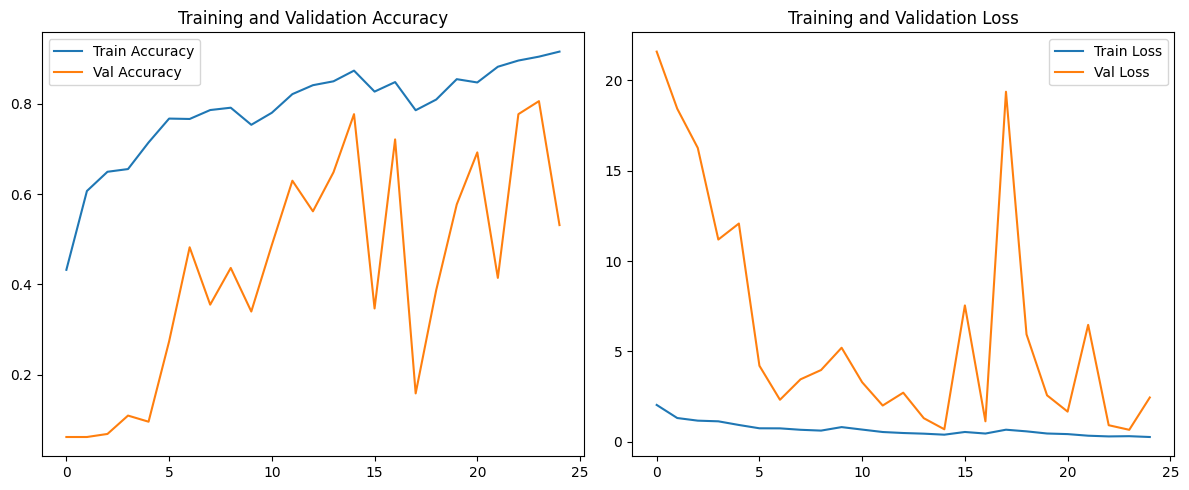

In [25]:
# ✅ Plot Accuracy and Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.tight_layout()
plt.show()

In [27]:
# ✅ Save Final Model
pickle.dump(model, open("cnn_model.pkl", "wb"))
print("[INFO] Model saved as cnn_model.pkl")

INFO:tensorflow:Assets written to: ram://dbd25321-4d10-48ee-a878-4d40617be53b/assets


INFO:tensorflow:Assets written to: ram://dbd25321-4d10-48ee-a878-4d40617be53b/assets


[INFO] Model saved as cnn_model.pkl


In [28]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test set
y_pred_probs = model.predict(x_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test, axis=1)  # one-hot to label


Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x0000018922144F70>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x0000018922144F70>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x0000018922144F70>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
19/19 [==============================] - 5s 255ms/step


In [29]:
# Accuracy, Precision, Recall, F1
acc = accuracy_score(y_true_labels, y_pred_labels)
prec = precision_score(y_true_labels, y_pred_labels, average='weighted')
rec = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')

print(f"✅ Accuracy: {acc:.2f}")
print(f"✅ Precision: {prec:.2f}")
print(f"✅ Recall: {rec:.2f}")
print(f"✅ F1 Score: {f1:.2f}")

# Detailed classification report
print("\n📋 Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=label_binarizer.classes_))


✅ Accuracy: 0.53
✅ Precision: 0.68
✅ Recall: 0.53
✅ F1 Score: 0.49

📋 Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.58      0.84      0.68        45
                     Pepper__bell___healthy       0.67      0.10      0.17        40
                      Potato___Early_blight       1.00      0.24      0.39        54
                       Potato___Late_blight       0.28      0.98      0.44        43
                           Potato___healthy       0.36      0.75      0.48        20
                      Tomato_Bacterial_spot       1.00      0.22      0.36        37
                        Tomato_Early_blight       0.42      0.24      0.31        41
                         Tomato_Late_blight       0.89      0.46      0.60        35
                           Tomato_Leaf_Mold       1.00      0.16      0.27        38
                  Tomato_Septoria_leaf_spot       0.39  

C:\Users\yuvan\AppData\Local\Temp\ipykernel_10080\3440130575.py:9: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\yuvan\anaconda3\envs\myenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


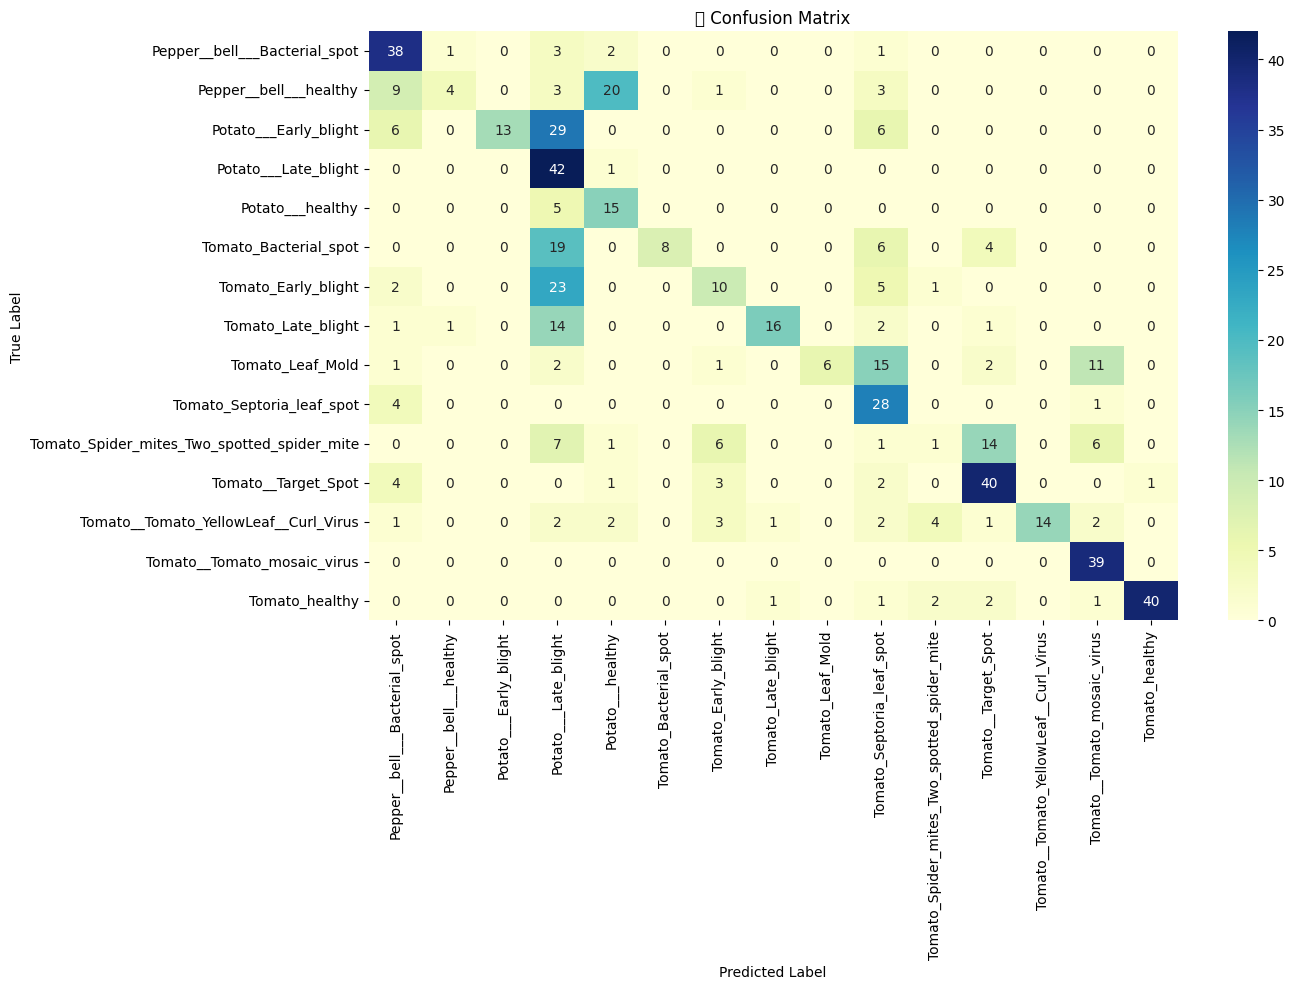

In [30]:
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=label_binarizer.classes_,
            yticklabels=label_binarizer.classes_)
plt.title("📊 Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [33]:
from tensorflow.keras.models import save_model

# ✅ Save as actual .h5 format (not pickle!)
model.save("cnn_model.h5")
